In [1]:
# Analysis on cooling effects from water bodies in Copenhagen 

# changes in Land Surface Temperature (LST) is used to detect the cooling effects

#lst_case.tif: The study area extent is created through a Union and a 
#Dissolve of the lakes_and_sea dataset and the official extents of 
#the two municipalities; the City of Copenhagen and Frederiksberg. 
#The calculated LST result is converted to EPSG:25832 with Project Raster 
#and cut to the case study extent with Extract by Mask and used as template 
#for further raster processing (Environment settings for extent, cell size, 
#mask, and snap raster). 

#lakes.shp and seas.shp: The lakes (or seas respectively) are selected in 
#the lakes_and_sea dataset (Select By Attributes) and extracted to their 
#own layer (Copy Features).  

#lakes_case.tif and seas_case.tif: The lakes (or seas respectively) are 
#converted into a raster (Raster to Polygon) with the same parameters as 
#the LST for the case study area.  

#euc_lake_distV2.tif and euc_seas_distV2.tif: Euclidean Distance is used 
#to calculate the distance to the nearest lake (or sea respectively) for 
#each raster cell following the parameters as the LST for the case study area.  

#lakes_source_near.tif and seas_source_near.tif: Euclidean Allocation is 
#used to provide the id in each raster cell of the nearest lake (or nearest 
#sea polygon respectively) following the parameters as the LST for the 
#case study area.


In [ ]:
#pip install statsmodels
#pip install pandas matplotlib
#pip install numpy
#pip install scipy
#pip install geopandas
#!pip install matplotlib-scalebar
#pip...

In [60]:
# SETUP
import pandas as pd
import rasterio
from rasterio.mask import mask
import rasterio.features
from rasterio.transform import array_bounds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import contextily as cx # for getting background maps
from shapely.geometry import mapping
from shapely.geometry import box # for getting bbox
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
import statsmodels.api as sm  # Import statsmodels for regression
from scipy import stats  # For regression analysis
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from libpysal.weights import DistanceBand



In [61]:
# SETUP
# import rasters
lst = rasterio.open('landsat20180603/lst_20180603_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
lst20200601 = rasterio.open('landsat20200601/lst_20200601_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
#lst20200601 = rasterio.open('landsat20200601/lst_20200601_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
lakes_case = rasterio.open('analysis_input_data/lakes_case.tif').read(1).astype('float64') # lakes=1 
lake_dist = rasterio.open('analysis_input_data/lakes_euc_dist.tif').read(1).astype('float64') # distances in metres to nearest lake
lakes_source_near = rasterio.open('analysis_input_data/lakes_source_near.tif').read(1).astype('float64') # id of nearest lake
seas_case = rasterio.open('analysis_input_data/seas_case.tif').read(1).astype('float64') # sea=1
sea_dist = rasterio.open('analysis_input_data/seas_euc_dist.tif').read(1).astype('float64') # distances in metres to sea
seas_source_near = rasterio.open('analysis_input_data/seas_source_near.tif').read(1).astype('float64') # id of nearest sea polygon


In [62]:
# SETUP
# Read the shapefile
lakes = gpd.read_file("analysis_input_data/lakes_casestudy.shp") # all lake polygons with attribute data
#lakes = gpd.read_file("lakes.shp") # all lake polygons with attribute data
print(lakes.head()) # Show the first few rows of the dataframe

# Read the shapefile
seas = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
print(seas.head()) # Show the first few rows of the dataframe

   fid_    id objekt_typ        kommune    area_ha  perimeter       details  \
0     0  1138         Sø  Frederiksberg   0.096052         73   obs cooling   
1     0   240         Sø      København  14.834820       2288  close to sea   
2     0  1140         Sø      København   3.693557        918   obs cooling   
3     0   517         Sø      København   6.313699        625   obs cooling   
4     0   516         Sø      København   0.804220        389   obs cooling   

   obs_dist    obs_lst    est_dist    est_lst   cool_trend  herbCross  \
0       315  27.794376  171.010603  25.908302     positive        NaN   
1       165  28.605614  242.849081  28.548786  seaPositive        NaN   
2       255  28.224209  223.030366  26.633807     positive        NaN   
3        75  24.103312  230.672440  26.776500     positive        NaN   
4       135  26.649478  201.300379  27.251340     positive        NaN   

   herbCoolCr  woodCoolCr  vegOverlap            vegExplain  \
0         NaN         N

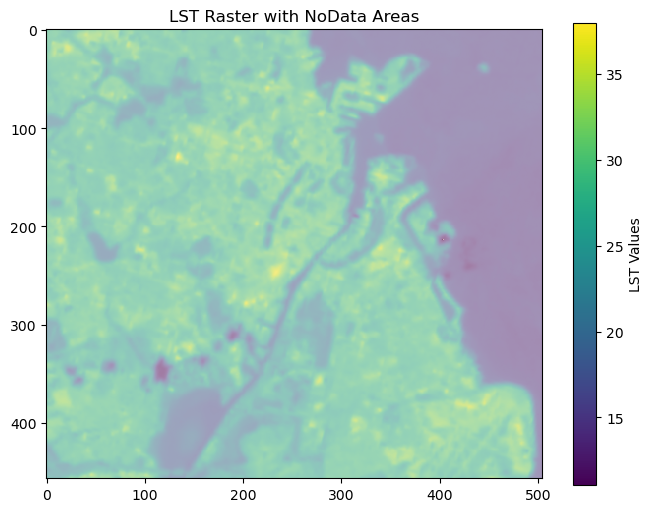

In [63]:
# SETUP
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST Raster with NoData Areas")
plt.show()

In [64]:
# SETUP
# Apply NoData mask from lst to all the other rasters
lake_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
sea_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_case[nodata_mask] = np.nan  # Set NoData where lst had NoData


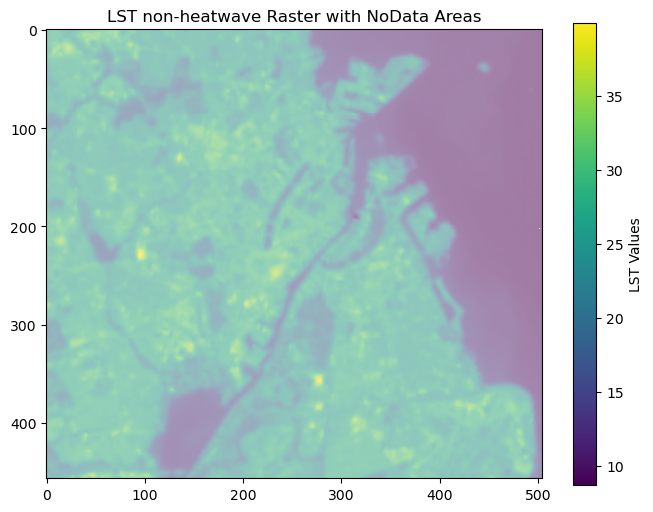

In [65]:
# SETUP
# Set NoData in LST
min_value_not_heat = np.nanmin(lst20200601)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst20200601[lst20200601 == min_value_not_heat] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask_not_heat = np.isnan(lst20200601) & np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst20200601, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask_not_heat, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST non-heatwave Raster with NoData Areas")
plt.show()

In [66]:
# CALCULATE OBSERVED TURNING DISTANCES FOR 2018 AND ADD AS COLUMN 
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes['id']

# Create a new column filled with NaNs
lakes['obs_zone'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index > 0 and not np.isnan(turn_mean_lst_values) and turn_mean_lst_values != -9999:
        turning_point_distance = bin_labels[turning_point_index]
        lakes.loc[lakes['id'] == lake_id, 'obs_zone'] = turning_point_distance
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes['obs_zone'].unique())
#print(lakes[lakes['obs_zone'].notna()]['obs_zone'].unique())


In [67]:
# CALCULATE OBSERVED TURNING POINT EFFECTS FOR 2018 AND ADD AS COLUMN 
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes_positive['id']

# Create a new column filled with NaNs
lakes_positive['obs_cooldif'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]
    #print(delta_lst)

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index > 0 and not np.isnan(turn_mean_lst_values):
        lakes_positive.loc[lakes_positive['id'] == lake_id, 'obs_cooldif'] = turn_mean_lst_values
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes_positive['obs_cooldif'].unique())
#print(lakes_positive[lakes_positive['obs_cooldif'].notna()]['obs_cooldif'].unique())

# only include polygons with observed cooling effects: 
lakes_positive = lakes_positive[lakes_positive['obs_cooldif'].notna()].copy()



In [68]:
# FOR ALTERNATIVE LST: CALCULATE OBSERVED TURNING DISTANCES AND ADD AS COLUMN 
### Analysis: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 720, 30)  # Bins: [0, 30, 60, ..., 420] #450
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids_non_heat = lakes['id']

# Create a new column filled with NaNs
lakes['obs_non_heat_zone'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids_non_heat:

    base_mask_non_heat = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst20200601) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask_non_heat) == 0:
        continue

    lst_at_30_60_mask_non_heat = base_mask_non_heat & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60_non_heat = np.mean(lst20200601[lst_at_30_60_mask_non_heat]) if np.any(lst_at_30_60_mask_non_heat) else np.nan

    mask_non_heat = base_mask_non_heat & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask_non_heat) == 0:
        continue

    raster1_vals_non_heat = lake_dist[mask_non_heat]
    raster2_vals_non_heat = lst20200601[mask_non_heat]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals_non_heat, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values_non_heat = [np.mean(raster2_vals_non_heat[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst_non_heat = [0 if bin_labels[i] == 45 else (val - lst_at_30_60_non_heat if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values_non_heat)]

    turning_point_index_non_heat = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values_non_heat = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60_non_heat) and not np.isnan(delta_lst_non_heat[index_75]):
            if (delta_lst_non_heat[index_75] > delta_lst_non_heat[index_45]):
                turning_point_index_non_heat = index_75
                turn_mean_lst_values_non_heat =  delta_lst_non_heat[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst_non_heat)): 
                    if np.isnan(delta_lst_non_heat[i]):
                        break
                    if delta_lst_non_heat[i] < delta_lst_non_heat[i - 1]:  
                        break  
                    turning_point_index_non_heat = i 
                    turn_mean_lst_values_non_heat = delta_lst_non_heat[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index_non_heat > 0 and not np.isnan(turn_mean_lst_values_non_heat) and turn_mean_lst_values_non_heat != -9999:
        turning_point_distance_non_heat = bin_labels[turning_point_index_non_heat]
        lakes.loc[lakes['id'] == lake_id, 'obs_non_heat_zone'] = turning_point_distance_non_heat
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes['obs_non_heat_zone'].unique())
#print(lakes[lakes['obs_non_heat_zone'].notna()]['obs_non_heat_zone'].unique())


In [69]:
# FOR ALTERNATIVE LST: CALCULATE OBSERVED TURNING POINT EFFECTS AND ADD AS COLUMN 
### Analysis: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes['id']

# Create a new column filled with NaNs
lakes['obs_cooldif_no_heat'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask_no_heat = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst20200601) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask_no_heat) == 0:
        continue

    lst_at_30_60_mask_no_heat = base_mask_no_heat & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60_no_heat = np.mean(lst20200601[lst_at_30_60_mask_no_heat]) if np.any(lst_at_30_60_mask_no_heat) else np.nan

    mask_no_heat = base_mask_no_heat & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask_no_heat) == 0:
        continue

    raster1_vals_no_heat = lake_dist[mask_no_heat]
    raster2_vals_no_heat = lst20200601[mask_no_heat]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals_no_heat, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values_no_heat = [np.mean(raster2_vals_no_heat[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst_no_heat = [0 if bin_labels[i] == 45 else (val - lst_at_30_60_no_heat if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values_no_heat)]
    #print(delta_lst)

    turning_point_index_no_heat = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values_no_heat = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60_no_heat) and not np.isnan(delta_lst_no_heat[index_75]):
            if (delta_lst_no_heat[index_75] > delta_lst_no_heat[index_45]):
                turning_point_index_no_heat = index_75
                turn_mean_lst_values_no_heat =  delta_lst_no_heat[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst_no_heat)): 
                    if np.isnan(delta_lst_no_heat[i]):
                        break
                    if delta_lst_no_heat[i] < delta_lst_no_heat[i - 1]:  
                        break  
                    turning_point_index_no_heat = i 
                    turn_mean_lst_values_no_heat = delta_lst_no_heat[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index_no_heat > 0 and not np.isnan(turn_mean_lst_values_no_heat):
        lakes.loc[lakes['id'] == lake_id, 'obs_cooldif_no_heat'] = turn_mean_lst_values_no_heat
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes['obs_cooldif_no_heat'].unique())
#print(lakes[lakes['obs_cooldif_no_heat'].notna()]['obs_cooldif_no_heat'].unique())

# only include polygons with observed cooling effects: 
lakes = lakes[lakes['obs_cooldif_no_heat'].notna()].copy()

In [70]:
# BUFFER LAKE POLYGONS BASED ON OBSERVED DISTANCES FOR 2020
# Subset lakes where obs_dist > 0
lakes_pos_draft = lakes[lakes['obs_non_heat_zone'] > 0].copy() #obs_dist
lakes_pos = lakes_pos_draft[lakes_pos_draft['obs_cooldif_no_heat'] > 0].copy() #obs_dist

# Create a new geometry column with buffered polygons
lakes_pos['geometry_buffered_obs2020'] = lakes_pos.geometry.buffer(lakes_pos['obs_non_heat_zone']) #obs_dist

In [71]:
# COMPARE OBSERVED DURING HEATWAVE WITH OBSERVED OUTSIDE HEATWAVE 

# Transfer dif-zone through mapping between observed outside heatwave minus observed during heatwave
obs_zone_dif_new_lst_map = lakes_positive.set_index('id')['obs_zone']
# Add column to lakes_positive
lakes_pos['obs_zone'] = lakes_pos['id'].map(obs_zone_dif_new_lst_map)
mask_obs_to_zero = lakes_pos['obs_zone'].isna() & lakes_pos['obs_non_heat_zone'].notna()
lakes_pos.loc[mask_obs_to_zero, 'obs_zone'] = 0
lakes_pos['obs_obs_zone_dif'] = lakes_pos['obs_non_heat_zone']-lakes_pos['obs_zone']
# if negative, the estimated zone has decreased 

# Transfer dif-cooling through mapping between observed outside heatwave minus observed during heatwave
obs_cool_dif_new_lst_map = lakes_positive.set_index('id')['obs_cooldif']
# Add column to lakes_positive
lakes_pos['obs_cooldif'] = lakes_pos['id'].map(obs_cool_dif_new_lst_map)
mask_obscool_to_zero = lakes_pos['obs_cooldif'].isna() & lakes_pos['obs_cooldif_no_heat'].notna()
lakes_pos.loc[mask_obscool_to_zero, 'obs_cooldif'] = 0
lakes_pos['obs_obs_cool_dif'] = lakes_pos['obs_cooldif_no_heat']-lakes_pos['obs_cooldif']
# if negative, the estimated cooling effect has decreased


In [72]:
pd.set_option('display.max_rows', None)  # show all rows

counts = (
    lakes_pos['obs_obs_zone_dif']
    .value_counts(dropna=False)
    .sort_index()   # <-- low to high
)
print(counts)

pd.reset_option('display.max_rows')  # optional: reset back to default

obs_obs_zone_dif
-240.0     1
-180.0     1
-120.0     1
-90.0      4
-60.0      8
-30.0     17
 0.0      63
 30.0     12
 60.0      4
 75.0      6
 90.0      3
 105.0     1
 120.0     1
 135.0    10
 150.0     1
 165.0     1
 195.0     4
 210.0     2
 225.0     1
 255.0     2
 315.0     1
Name: count, dtype: int64


In [73]:
pd.set_option('display.max_rows', None)  # show all rows

counts = (
    lakes_pos['obs_obs_cool_dif']
    .value_counts(dropna=False)
    .sort_index()   # <-- low to high
)
print(counts)

pd.reset_option('display.max_rows')  # optional: reset back to default

obs_obs_cool_dif
-8.611998    1
-2.530882    1
-2.416738    1
-0.894115    1
-0.836586    1
-0.645396    1
-0.594044    1
-0.545570    1
-0.532003    1
-0.516811    1
-0.450640    1
-0.416337    1
-0.399187    1
-0.270595    1
-0.244755    1
-0.220713    1
-0.132357    1
-0.130649    1
-0.101140    1
-0.082852    1
-0.080140    1
-0.055135    1
-0.053080    1
-0.012015    1
-0.009602    1
-0.003569    1
-0.003477    1
 0.006716    1
 0.009013    1
 0.019708    1
 0.021637    1
 0.021680    1
 0.024450    1
 0.033361    1
 0.038313    1
 0.039396    1
 0.081820    1
 0.091602    1
 0.103793    1
 0.120071    1
 0.121567    1
 0.134443    1
 0.134892    1
 0.145040    1
 0.149446    1
 0.161776    1
 0.165092    1
 0.179148    1
 0.195218    1
 0.198820    1
 0.209346    1
 0.220934    1
 0.227474    1
 0.262108    1
 0.268135    1
 0.271995    1
 0.288807    1
 0.294193    1
 0.299351    1
 0.300268    1
 0.314118    1
 0.324705    1
 0.328723    1
 0.329887    1
 0.356544    1
 0.36197

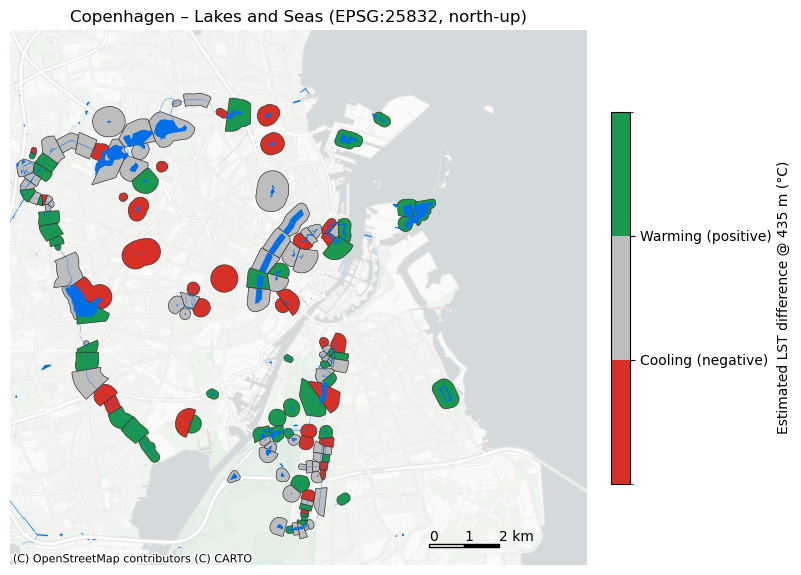

In [74]:
# MAP ZONE-DIFFERENCE OBSERVED HEATWAVE VS. OBSERVED NON-HEATWAVE 
# Create a new geometry column with buffered polygons
#lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist
centroids = lakes_pos.geometry.centroid

# Create Voronoi diagram with envelope = union of buffered polygons
vor_obs = voronoi_diagram(
    MultiPoint(list(centroids)),
    envelope=lakes_pos['geometry_buffered_obs2020'].union_all()  # use union_all() instead of unary_union
)

# Convert Voronoi polygons to a GeoDataFrame
vor_obs_gdf = gpd.GeoDataFrame(geometry=list(vor_obs.geoms), crs=lakes_pos.crs)

# Clip each buffer to its Voronoi polygon
buffers_cut = []
# Loop over each lake buffer
for i, buffer_geom in enumerate(lakes_pos['geometry_buffered_obs2020']):
    centroid = lakes_pos.geometry.iloc[i].centroid  # lake centroid
    # Find the Voronoi polygon that contains this centroid
    matching_cell = vor_obs_gdf[vor_obs_gdf.geometry.contains(centroid)]
    if not matching_cell.empty:
        buffers_cut.append(buffer_geom.intersection(matching_cell.geometry.iloc[0]))
    else:
        # fallback if something went wrong
        buffers_cut.append(buffer_geom)
        
# Create a GeoDataFrame of clipped buffers
vor_obs_gdf_clipped = gpd.GeoDataFrame({
    'geometry': buffers_cut,
    'id': lakes_pos['id'],
    'obs_obs_zone_dif': lakes_pos['obs_obs_zone_dif']
}, crs=lakes_pos.crs)

# Remove empty geometries (just in case)
vor_obs_gdf_clipped = vor_obs_gdf_clipped[~vor_obs_gdf_clipped.is_empty].reset_index(drop=True)

bins_cool_new = [-1e6, -1e-9, 1e-9, 1e6]  # effectively (-inf, 0, +inf)

# Example colors (replace with your preferred palette)
colors_cool_new = [
    "#D73027",  # red = heatwave has smaller zone 
    "#BDBDBD",  # grey = no change (zero)
    "#1A9850"  # green = heatwave has larger zone
]

# Colormap and boundary norm
cmap_cool_new = ListedColormap(colors_cool_new)
norm_cool_new = BoundaryNorm(bins_cool_new, cmap_cool_new.N)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# --- Cooling effect
vor_obs_gdf_clipped.plot(
    ax=ax,
    column='obs_obs_zone_dif',
    cmap=cmap_cool_new,
    norm=norm_cool_new,
    edgecolor="#343433",
    linewidth=0.5,
    alpha=1.0
)

# --- Lakes (full color, north-up) ---
#lakes[lakes['details'] == "obs cooling"].plot(
lakes = gpd.read_file("analysis_input_data/lakes_casestudy.shp") # all lake polygons with attribute data
lakes.plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Add color legend ---
sm_cool_new = ScalarMappable(cmap=cmap_cool_new, norm=norm_cool_new)
sm_cool_new.set_array([])
cbar = fig.colorbar(sm_cool_new, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks([-0.5, 0.5])
cbar.set_ticklabels(["Cooling (negative)", "Warming (positive)"])
cbar.set_label("Estimated LST difference @ 435 m (°C)")

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "obs2018_obs2020_zone_dif.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

# Negative zone due to decreasing with time = red
# Positive zone due to increasing with time = green 


In [75]:
print("number of red: ")
print((lakes_pos['obs_obs_zone_dif'] < 0).sum())
print("red average area: ")
print(lakes_pos.loc[lakes_pos["obs_obs_zone_dif"] < 0, "area_ha"].mean())
print("number of green: ")
print((lakes_pos['obs_obs_zone_dif'] > 0).sum())
print("green average area: ")
print(lakes_pos.loc[lakes_pos["obs_obs_zone_dif"] > 0, "area_ha"].mean())

number of red: 
32
red average area: 
2.068827186552544
number of green: 
49
green average area: 
8.211060208328371


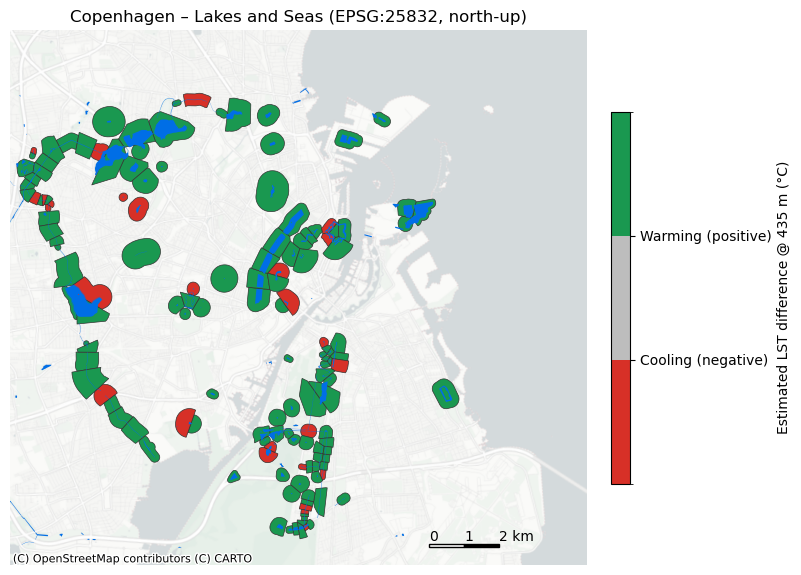

In [76]:
# MAP LST-DIFFERENCE OBSERVED HEATWAVE VS. OBSERVED NON-HEATWAVE
# Create a new geometry column with buffered polygons
#lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist
centroids = lakes_pos.geometry.centroid

# Create Voronoi diagram with envelope = union of buffered polygons
vor_obs = voronoi_diagram(
    MultiPoint(list(centroids)),
    envelope=lakes_pos['geometry_buffered_obs2020'].union_all()  # use union_all() instead of unary_union
)

# Convert Voronoi polygons to a GeoDataFrame
vor_obs_gdf = gpd.GeoDataFrame(geometry=list(vor_obs.geoms), crs=lakes_pos.crs)

# Clip each buffer to its Voronoi polygon
buffers_cut = []
# Loop over each lake buffer
for i, buffer_geom in enumerate(lakes_pos['geometry_buffered_obs2020']):
    centroid = lakes_pos.geometry.iloc[i].centroid  # lake centroid
    # Find the Voronoi polygon that contains this centroid
    matching_cell = vor_obs_gdf[vor_obs_gdf.geometry.contains(centroid)]
    if not matching_cell.empty:
        buffers_cut.append(buffer_geom.intersection(matching_cell.geometry.iloc[0]))
    else:
        # fallback if something went wrong
        buffers_cut.append(buffer_geom)
        
# Create a GeoDataFrame of clipped buffers
vor_obs_gdf_clipped = gpd.GeoDataFrame({
    'geometry': buffers_cut,
    'id': lakes_pos['id'],
    'obs_obs_cool_dif': lakes_pos['obs_obs_cool_dif']
}, crs=lakes_pos.crs)

# Remove empty geometries (just in case)
vor_obs_gdf_clipped = vor_obs_gdf_clipped[~vor_obs_gdf_clipped.is_empty].reset_index(drop=True)

bins_cool_new = [-1e6, -1e-9, 1e-9, 1e6]  # effectively (-inf, 0, +inf)

# Example colors (replace with your preferred palette)
colors_cool_new = [
    "#D73027",  # red = heatwave has smaller zone 
    "#BDBDBD",  # grey = no change (zero)
    "#1A9850"  # green = heatwave has larger zone
]

# Colormap and boundary norm
cmap_cool_new = ListedColormap(colors_cool_new)
norm_cool_new = BoundaryNorm(bins_cool_new, cmap_cool_new.N)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# --- Cooling effect
vor_obs_gdf_clipped.plot(
    ax=ax,
    column='obs_obs_cool_dif',
    cmap=cmap_cool_new,
    norm=norm_cool_new,
    edgecolor="#343433",
    linewidth=0.5,
    alpha=1.0
)

# --- Lakes (full color, north-up) ---
#lakes[lakes['details'] == "obs cooling"].plot(
lakes.plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Add color legend ---
sm_cool_new = ScalarMappable(cmap=cmap_cool_new, norm=norm_cool_new)
sm_cool_new.set_array([])
cbar = fig.colorbar(sm_cool_new, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks([-0.5, 0.5])
cbar.set_ticklabels(["Cooling (negative)", "Warming (positive)"])
cbar.set_label("Estimated LST difference @ 435 m (°C)")

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "obs2018_obs2020_cool_dif.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

# Negative cooling color due to decreasing with time = red
# Positive cooling color due to increasing with time = green 



In [77]:
print("number of red: ")
print((lakes_pos['obs_obs_cool_dif'] < 0).sum())
print("red average area: ")
print(lakes_pos.loc[lakes_pos["obs_obs_cool_dif"] < 0, "area_ha"].mean())
print("red average cooling dif: ")
print(lakes_pos.loc[lakes_pos["obs_obs_cool_dif"] < 0, "obs_obs_cool_dif"].mean())
print("number of green: ")
print((lakes_pos['obs_obs_cool_dif'] > 0).sum())
print("green average area: ")
print(lakes_pos.loc[lakes_pos["obs_obs_cool_dif"] > 0, "area_ha"].mean())
print("green average cooling dif: ")
print(lakes_pos.loc[lakes_pos["obs_obs_cool_dif"] > 0, "obs_obs_cool_dif"].mean())

number of red: 
27
red average area: 
1.4914067870457035
red average cooling dif: 
-0.7700143491881078
number of green: 
117
green average area: 
8.247897696061724
green average cooling dif: 
0.9524223325067415
